## Calculate balanced machine learning measures, Full Data Set, All 6 analyses

From request [Calculate balanced machine learning measures](https://trello.com/c/fGlOzVVt)

Weighted accuracy, ppv, npv, specificity, and sensitivity [See Sample Calculated Metrics](Machine_Learning_Metric_Calc.xlsx)

## Imports and Function Definitions

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [22]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx')
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.1s finished


Best parameters set found on development set:

{'classifier__C': 0.088586679041008323}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89        55
        1.0       0.99      0.92      0.95       146

avg / total       0.94      0.94      0.94       201


Confusion matrix, without normalization
[[ 53   2]
 [ 11 135]]

recall	0.924657534247
precision	0.985401459854
auc	0.944146948941
specificity	0.963636363636
npv	0.828125
accuracy	0.935323383085
weighted_sensitivity	0.924657534247
weighted_ppv	0.962161461708
weighted_specificity	0.963636363636
weighted_npv	0.927484118423
weighted_accuracy	0.944146948941


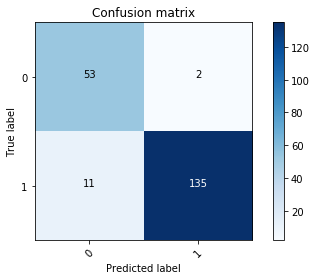

In [23]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.224346971512	0.0616949301641
score_time	0.067715549469	0.0200705697162
test_recall	0.944632683658	0.0129225120211
train_recall	0.962804222415	0.00518295705752
test_precision	0.983893486355	0.0087585949186
train_precision	0.991544320506	0.00256957708087
test_auc	0.952164826678	0.011504948455
train_auc	0.970749923649	0.0038961200225
test_specificity	0.959696969697	0.0221495598081
train_specificity	0.978695624882	0.00653898971576
test_npv	0.870735053432	0.0254784348043
train_npv	0.910479722975	0.0114338099385
test_accuracy	0.948818313215	0.00993100661661
train_accuracy	0.967229361371	0.00394008264747
test_weighted_sensitivity	0.944632683658	0.0129225120211
train_weighted_sensitivity	0.962804222415	0.00518295705752
test_weighted_ppv	0.959630936559	0.0219463441353
train_weighted_ppv	0.978398452649	0.00649589874077
test_weighted_specificity	0.959696969697	0.0221495598081
train_weighted_specificity	0.978695624882	0.00653898971576
test_weighted_npv	0.945636050437	0.0117622195573
tra

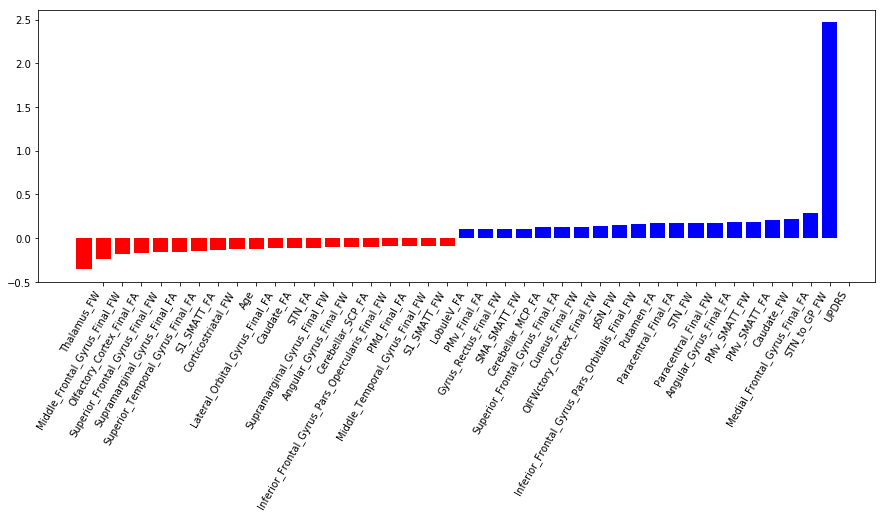

Age	-0.130682251773
Sex	-0.0270564539612
UPDRS	2.46978647903
aSN_FA	-0.0272534149482
Caudate_FA	-0.119249032117
CC2_FA	0.0971422740358
GP_FA	-0.0787320301502
LobuleVI_FA	0.0998943917337
LobuleV_FA	-0.0884594354481
MCP_FA	0.00390229272272
pSN_FA	0.0985640329884
Putamen_FA	0.154717320261
SCP_FA	0.0817276572593
STN_FA	-0.114475508228
Thalamus_FA	0.0936955263024
Vermis_FA	0.0334388416953
RN_FA	-0.00698643934278
PPN_FA	-0.00616586026318
Dentate_FA	-0.0518755931886
CC1_FA	-0.0727512204551
aSN_FW	-0.0512586993487
Caudate_FW	0.20544113546
CC2_FW	-0.0221968781225
GP_FW	-0.0884040790317
LobuleVI_FW	0.0158920658613
LobuleV_FW	-0.0618162869999
MCP_FW	-0.0196527770065
pSN_FW	0.142323473851
Putamen_FW	-0.0476574978057
SCP_FW	0.0906722658978
STN_FW	0.17621562207
Thalamus_FW	-0.357947373471
Vermis_FW	-0.00817330750202
RN_FW	0.00108984231171
PPN_FW	0.0744727094864
Dentate_FW	-0.0831860458928
CC1_FW	0.0691864517768
Angular_Gyrus_Final_FA	0.176923827723
Anterior_Orbital_Gyrus_Final_FA	-0.0240510404816
Ca

In [25]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89        55
        1.0       0.99      0.92      0.95       146

avg / total       0.94      0.94      0.94       201



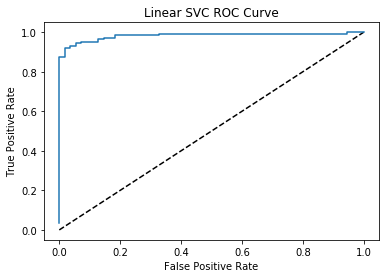

0.0 0.0342465753425
0.0 0.876712328767
0.0181818181818 0.876712328767
0.0181818181818 0.917808219178
0.0363636363636 0.917808219178
0.0363636363636 0.931506849315
0.0545454545455 0.931506849315
0.0545454545455 0.945205479452
0.0727272727273 0.945205479452
0.0727272727273 0.952054794521
0.127272727273 0.952054794521
0.127272727273 0.965753424658
0.145454545455 0.965753424658
0.145454545455 0.972602739726
0.181818181818 0.972602739726
0.181818181818 0.986301369863
0.327272727273 0.986301369863
0.327272727273 0.993150684932
0.945454545455 0.993150684932
0.945454545455 1.0
1.0 1.0


In [26]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.94       105
        1.0       0.79      0.93      0.85        40

avg / total       0.92      0.91      0.91       145


Confusion matrix, without normalization
[[95 10]
 [ 3 37]]

recall	0.925
precision	0.787234042553
auc	0.914880952381
specificity	0.904761904762
npv	0.969387755102
accuracy	0.910344827586
weighted_sensitivity	0.925
weighted_ppv	0.906651108518
weighted_specificity	0.904761904762
weighted_npv	0.923450789793
weighted_accuracy	0.914880952381


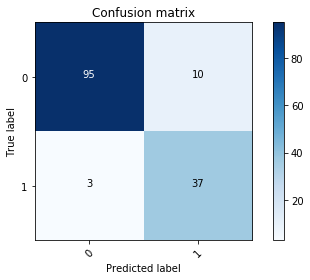

In [27]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [28]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.206508779526	0.060764896362
score_time	0.102405738831	0.0335817033589
test_recall	0.792268907563	0.0578073084416
train_recall	0.874298821812	0.0114900804038
test_precision	0.791112313899	0.0569963269966
train_precision	0.879724522761	0.0165496489889
test_auc	0.850590942791	0.0284096292408
train_auc	0.911594805018	0.00513659890986
test_specificity	0.908912978019	0.0286134476964
train_specificity	0.948890788224	0.00816912098629
test_npv	0.911875836999	0.0225622132414
train_npv	0.946597504627	0.00450272505247
test_accuracy	0.873998129141	0.0223368698273
train_accuracy	0.926593662476	0.00498020231121
test_weighted_sensitivity	0.792268907563	0.0578073084416
train_weighted_sensitivity	0.874298821812	0.0114900804038
test_weighted_ppv	0.897874981597	0.0299698444842
train_weighted_ppv	0.944885984386	0.00803111935193
test_weighted_specificity	0.908912978019	0.0286134476964
train_weighted_specificity	0.948890788224	0.00816912098629
test_weighted_npv	0.816368748607	0.0423628808482
train

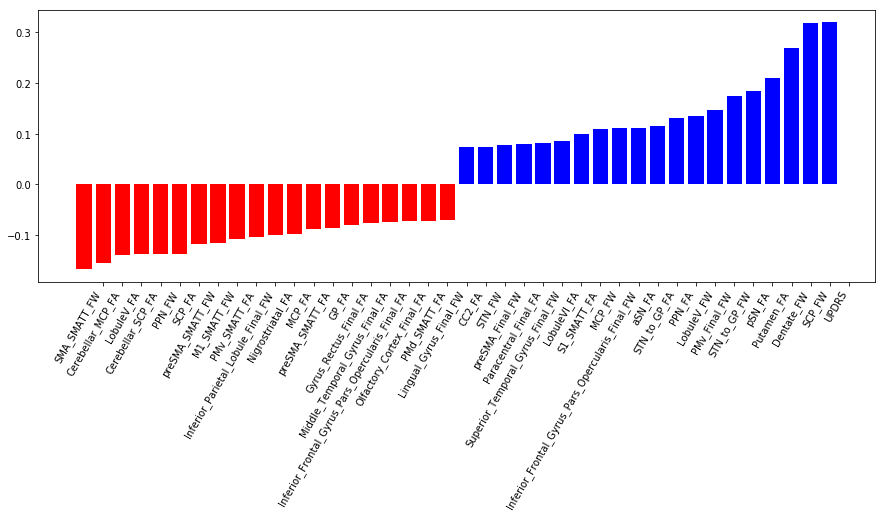

Age	-0.0406126112738
Sex	0.0
UPDRS	0.32018775039
aSN_FA	0.110928369522
Caudate_FA	-0.0445443927948
CC2_FA	0.0731134195356
GP_FA	-0.0859598289437
LobuleVI_FA	0.0858581813149
LobuleV_FA	-0.13985706971
MCP_FA	-0.0976596868706
pSN_FA	0.184044930855
Putamen_FA	0.209030426775
SCP_FA	-0.137373329869
STN_FA	0.0592858737686
Thalamus_FA	-0.0405980946063
Vermis_FA	0.0692183597681
RN_FA	-0.0236590163246
PPN_FA	0.131216495795
Dentate_FA	0.059202767254
CC1_FA	0.00261512272507
aSN_FW	0.037385718773
Caudate_FW	0.0376521766151
CC2_FW	-0.0392794024224
GP_FW	0.0411587294057
LobuleVI_FW	-0.03394727397
LobuleV_FW	0.134991245228
MCP_FW	0.108832862129
pSN_FW	0.0258832491702
Putamen_FW	0.0290785207225
SCP_FW	0.318450950478
STN_FW	0.0731293495953
Thalamus_FW	0.0568910874207
Vermis_FW	0.0537895424267
RN_FW	-0.0157329405705
PPN_FW	-0.137395509061
Dentate_FW	0.269609785754
CC1_FW	0.0378641608274
Angular_Gyrus_Final_FA	0.0281778184652
Anterior_Orbital_Gyrus_Final_FA	0.01001307766
Calcarine_Sulcus_Final_FA	-0.03085

In [29]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.94       105
        1.0       0.79      0.93      0.85        40

avg / total       0.92      0.91      0.91       145



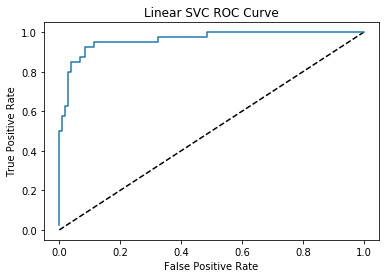

0.0 0.025
0.0 0.5
0.00952380952381 0.5
0.00952380952381 0.575
0.0190476190476 0.575
0.0190476190476 0.625
0.0285714285714 0.625
0.0285714285714 0.8
0.0380952380952 0.8
0.0380952380952 0.85
0.0666666666667 0.85
0.0666666666667 0.875
0.0857142857143 0.875
0.0857142857143 0.925
0.114285714286 0.925
0.114285714286 0.95
0.32380952381 0.95
0.32380952381 0.975
0.485714285714 0.975
0.485714285714 1.0
1.0 1.0


In [30]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished


Best parameters set found on development set:

{'classifier__C': 0.0023357214690901212}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.98      0.83      0.90       131
        1.0       0.35      0.86      0.50        14

avg / total       0.92      0.83      0.86       145


Confusion matrix, without normalization
[[109  22]
 [  2  12]]

recall	0.857142857143
precision	0.352941176471
auc	0.844601962923
specificity	0.832061068702
npv	0.981981981982
accuracy	0.834482758621
weighted_sensitivity	0.857142857143
weighted_ppv	0.836170212766
weighted_specificity	0.832061068702
weighted_npv	0.853467561521
weighted_accuracy	0.844601962923


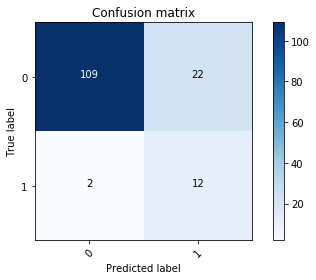

In [31]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [32]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.294320583344	0.0545685600406
score_time	0.152516222	0.0264654296636
test_recall	0.671428571429	0.0857142857143
train_recall	0.807142857143	0.0133630620956
test_precision	0.543201896143	0.12413742968
train_precision	0.605954183236	0.0486051776886
test_auc	0.794431039743	0.0501869392207
train_auc	0.866977147124	0.0135002370529
test_specificity	0.917433508057	0.0290089493872
train_specificity	0.926811437106	0.0142163121412
test_npv	0.953044458259	0.0122520410261
train_npv	0.972150328346	0.002288393255
test_accuracy	0.887706146927	0.0309710438094
train_accuracy	0.912343598719	0.0139989256916
test_weighted_sensitivity	0.671428571429	0.0857142857143
train_weighted_sensitivity	0.807142857143	0.0133630620956
test_weighted_ppv	0.888973394623	0.0418759571179
train_weighted_ppv	0.916895131087	0.0159485653053
test_weighted_specificity	0.917433508057	0.0290089493872
train_weighted_specificity	0.926811437106	0.0142163121412
test_weighted_npv	0.739377060857	0.0532450053614
train_weighted_n

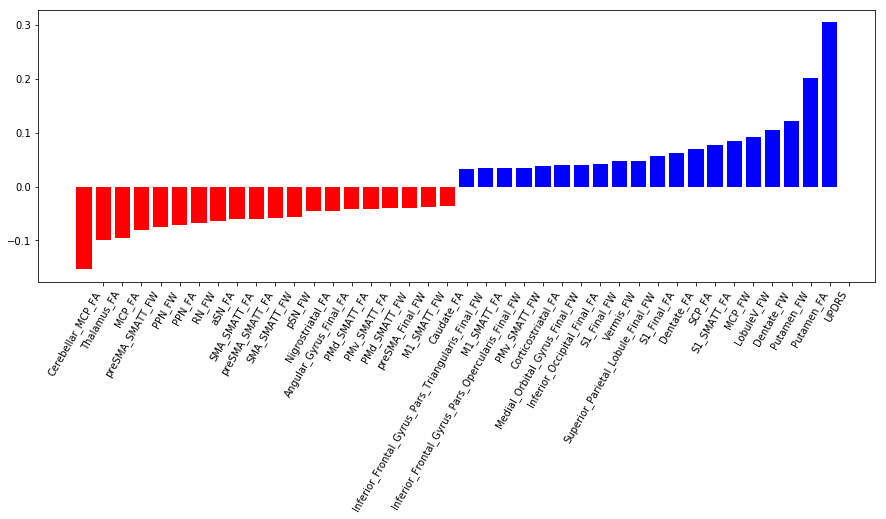

Age	-0.00307381424334
Sex	0.0
UPDRS	0.304516476996
aSN_FA	-0.0644839007908
Caudate_FA	-0.0365934707678
CC2_FA	0.0182633449831
GP_FA	0.0295037679376
LobuleVI_FA	-0.0338226982826
LobuleV_FA	-0.0361612286669
MCP_FA	-0.0957421990744
pSN_FA	-0.0165345182675
Putamen_FA	0.201981854383
SCP_FA	0.0704173178946
STN_FA	-0.0271380622119
Thalamus_FA	-0.0996090230822
Vermis_FA	-0.0107338392472
RN_FA	-0.011396937149
PPN_FA	-0.0716328709468
Dentate_FA	0.0628895560936
CC1_FA	-0.0118234284172
aSN_FW	-0.00540363927211
Caudate_FW	0.00204939433102
CC2_FW	-0.02694870929
GP_FW	0.0313922135605
LobuleVI_FW	0.0145830940653
LobuleV_FW	0.091257496354
MCP_FW	0.0848864464531
pSN_FW	-0.057289926627
Putamen_FW	0.121981672324
SCP_FW	-0.00115772151395
STN_FW	-0.00600094423267
Thalamus_FW	0.0209246257084
Vermis_FW	0.0464332726238
RN_FW	-0.0670518336672
PPN_FW	-0.0758335904158
Dentate_FW	0.104984927434
CC1_FW	-0.02268483933
Angular_Gyrus_Final_FA	-0.044831153986
Anterior_Orbital_Gyrus_Final_FA	0.00605229853577
Calcarine_S

In [33]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.98      0.83      0.90       131
        1.0       0.35      0.86      0.50        14

avg / total       0.92      0.83      0.86       145



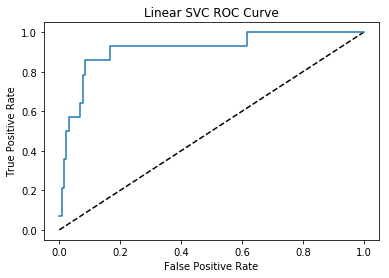

0.0 0.0714285714286
0.00763358778626 0.0714285714286
0.00763358778626 0.214285714286
0.0152671755725 0.214285714286
0.0152671755725 0.357142857143
0.0229007633588 0.357142857143
0.0229007633588 0.5
0.030534351145 0.5
0.030534351145 0.571428571429
0.0687022900763 0.571428571429
0.0687022900763 0.642857142857
0.0763358778626 0.642857142857
0.0763358778626 0.785714285714
0.0839694656489 0.785714285714
0.0839694656489 0.857142857143
0.167938931298 0.857142857143
0.167938931298 0.928571428571
0.618320610687 0.928571428571
0.618320610687 1.0
1.0 1.0


In [34]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.95       119
        1.0       0.78      0.81      0.79        26

avg / total       0.93      0.92      0.92       145


Confusion matrix, without normalization
[[113   6]
 [  5  21]]

recall	0.807692307692
precision	0.777777777778
auc	0.878636069813
specificity	0.949579831933
npv	0.957627118644
accuracy	0.924137931034
weighted_sensitivity	0.807692307692
weighted_ppv	0.941242937853
weighted_specificity	0.949579831933
weighted_npv	0.83158788565
weighted_accuracy	0.878636069813


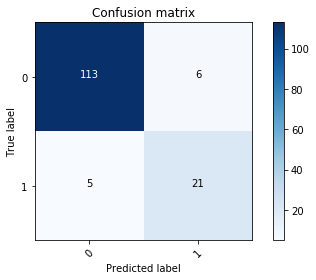

In [35]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [36]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0807171344757	0.00771245253143
score_time	0.0428974628448	0.00444714009115
test_recall	0.816666666667	0.0531117847375
train_recall	0.907816632383	0.0221834063489
test_precision	0.838421052632	0.0926553016403
train_precision	0.881632205004	0.0347314656739
test_auc	0.890493421053	0.0356720033147
train_auc	0.94051143817	0.0100866888804
test_specificity	0.964320175439	0.0215907559332
train_specificity	0.973206243956	0.00918933879708
test_npv	0.960191870332	0.012313708521
train_npv	0.979945099561	0.00468693969265
test_accuracy	0.937943720447	0.0262119779764
train_accuracy	0.961565223461	0.00692530989553
test_weighted_sensitivity	0.816666666667	0.0531117847375
train_weighted_sensitivity	0.907816632383	0.0221834063489
test_weighted_ppv	0.957476598401	0.0258444439522
train_weighted_ppv	0.971502037805	0.00922537628918
test_weighted_specificity	0.964320175439	0.0215907559332
train_weighted_specificity	0.973206243956	0.00918933879708
test_weighted_npv	0.841533372182	0.0417090811939
tra

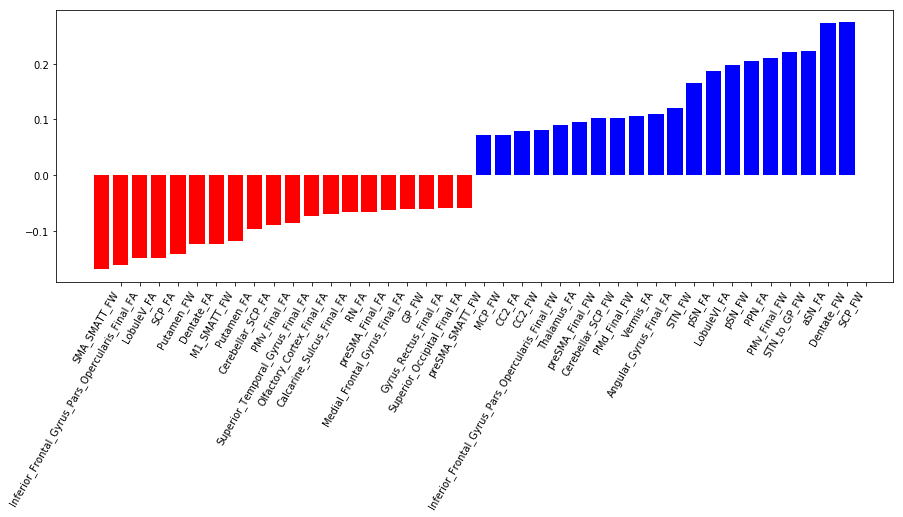

Age	0.0479517377262
Sex	0.0
UPDRS	-0.0316967096095
aSN_FA	0.223342960305
Caudate_FA	-0.00192703216019
CC2_FA	0.0725715024703
GP_FA	-0.0506329353472
LobuleVI_FA	0.187203617602
LobuleV_FA	-0.148849070125
MCP_FA	0.0433922444311
pSN_FA	0.164932575193
Putamen_FA	-0.118964919049
SCP_FA	-0.148267409513
STN_FA	0.0592973426167
Thalamus_FA	0.0893014356593
Vermis_FA	0.105188558231
RN_FA	-0.0661440924714
PPN_FA	0.205477619565
Dentate_FA	-0.124286784949
CC1_FA	0.0226078496269
aSN_FW	0.0273730777658
Caudate_FW	0.0194081120431
CC2_FW	0.0791053021557
GP_FW	-0.0617683341214
LobuleVI_FW	-0.0322801030488
LobuleV_FW	-0.018173543752
MCP_FW	0.0722032971534
pSN_FW	0.197363835155
Putamen_FW	-0.141133228904
SCP_FW	0.274576482451
STN_FW	0.119998014945
Thalamus_FW	0.0318034204116
Vermis_FW	0.00442755313898
RN_FW	0.0184334448763
PPN_FW	0.0222926060692
Dentate_FW	0.272395256383
CC1_FW	0.00595984720509
Angular_Gyrus_Final_FA	0.11007527298
Anterior_Orbital_Gyrus_Final_FA	0.0388326097723
Calcarine_Sulcus_Final_FA	-0.

In [37]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.95       119
        1.0       0.78      0.81      0.79        26

avg / total       0.93      0.92      0.92       145



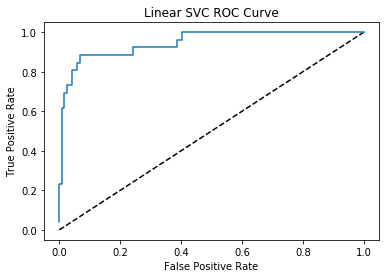

0.0 0.0384615384615
0.0 0.230769230769
0.00840336134454 0.230769230769
0.00840336134454 0.615384615385
0.0168067226891 0.615384615385
0.0168067226891 0.692307692308
0.0252100840336 0.692307692308
0.0252100840336 0.730769230769
0.0420168067227 0.730769230769
0.0420168067227 0.807692307692
0.0588235294118 0.807692307692
0.0588235294118 0.846153846154
0.0672268907563 0.846153846154
0.0672268907563 0.884615384615
0.243697478992 0.884615384615
0.243697478992 0.923076923077
0.386554621849 0.923076923077
0.386554621849 0.961538461538
0.403361344538 0.961538461538
0.403361344538 1.0
1.0 1.0


In [38]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.7s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[10  3]
 [ 5 25]]

recall	0.833333333333
precision	0.892857142857
auc	0.801282051282
specificity	0.769230769231
npv	0.666666666667
accuracy	0.813953488372
weighted_sensitivity	0.833333333333
weighted_ppv	0.78313253012
weighted_specificity	0.769230769231
weighted_npv	0.821917808219
weighted_accuracy	0.801282051282


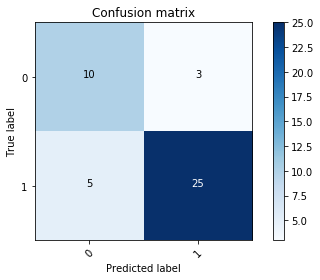

In [39]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [40]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0133985042572	0.0028714192987
score_time	0.0171047687531	0.0039288634041
test_recall	0.858947368421	0.0729398492365
train_recall	0.881234177215	0.0263255383405
test_precision	0.923698830409	0.0264310503776
train_precision	0.986255086072	0.0122710423822
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.900952380952	0.0358125631942
train_specificity	0.982330827068	0.0158331734056
test_npv	0.826587301587	0.078020353825
train_npv	0.856753770423	0.0255876012875
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634
test_weighted_sensitivity	0.858947368421	0.0729398492365
train_weighted_sensitivity	0.881234177215	0.0263255383405
test_weighted_ppv	0.896990316031	0.0348306237744
train_weighted_ppv	0.980908144509	0.0170788940642
test_weighted_specificity	0.900952380952	0.0358125631942
train_weighted_specificity	0.982330827068	0.0158331734056
test_weighted_npv	0.868289102926	0.0599799614805
train_weig

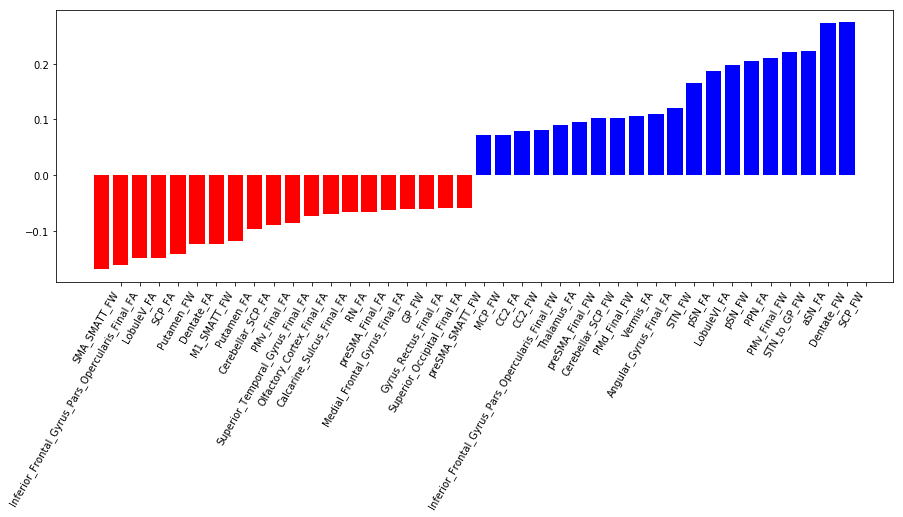

Age	0.0479517377262
Sex	0.0
UPDRS	-0.0316967096095
aSN_FA	0.223342960305
Caudate_FA	-0.00192703216019
CC2_FA	0.0725715024703
GP_FA	-0.0506329353472
LobuleVI_FA	0.187203617602
LobuleV_FA	-0.148849070125
MCP_FA	0.0433922444311
pSN_FA	0.164932575193
Putamen_FA	-0.118964919049
SCP_FA	-0.148267409513
STN_FA	0.0592973426167
Thalamus_FA	0.0893014356593
Vermis_FA	0.105188558231
RN_FA	-0.0661440924714
PPN_FA	0.205477619565
Dentate_FA	-0.124286784949
CC1_FA	0.0226078496269
aSN_FW	0.0273730777658
Caudate_FW	0.0194081120431
CC2_FW	0.0791053021557
GP_FW	-0.0617683341214
LobuleVI_FW	-0.0322801030488
LobuleV_FW	-0.018173543752
MCP_FW	0.0722032971534
pSN_FW	0.197363835155
Putamen_FW	-0.141133228904
SCP_FW	0.274576482451
STN_FW	0.119998014945
Thalamus_FW	0.0318034204116
Vermis_FW	0.00442755313898
RN_FW	0.0184334448763
PPN_FW	0.0222926060692
Dentate_FW	0.272395256383
CC1_FW	0.00595984720509
Angular_Gyrus_Final_FA	0.11007527298
Anterior_Orbital_Gyrus_Final_FA	0.0388326097723
Calcarine_Sulcus_Final_FA	-0.

In [41]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.67      0.77      0.71        13
        1.0       0.89      0.83      0.86        30

avg / total       0.82      0.81      0.82        43



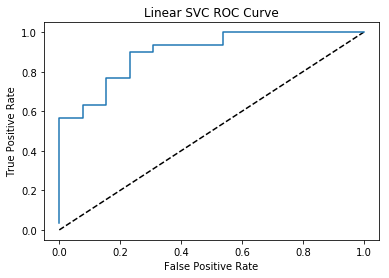

0.0 0.0333333333333
0.0 0.566666666667
0.0769230769231 0.566666666667
0.0769230769231 0.633333333333
0.153846153846 0.633333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.9
0.307692307692 0.9
0.307692307692 0.933333333333
0.538461538462 0.933333333333
0.538461538462 1.0
1.0 1.0


In [42]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43


Confusion matrix, without normalization
[[25  5]
 [ 3 10]]

recall	0.769230769231
precision	0.666666666667
auc	0.801282051282
specificity	0.833333333333
npv	0.892857142857
accuracy	0.813953488372
weighted_sensitivity	0.769230769231
weighted_ppv	0.821917808219
weighted_specificity	0.833333333333
weighted_npv	0.78313253012
weighted_accuracy	0.801282051282


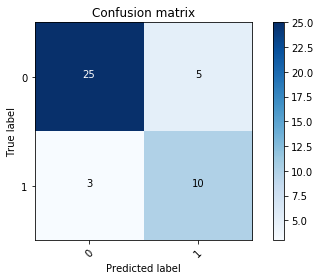

In [43]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [44]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0157962322235	0.00318317598976
score_time	0.0125022411346	0.00232744304061
test_recall	0.900952380952	0.0358125631942
train_recall	0.982330827068	0.0158331734056
test_precision	0.826587301587	0.078020353825
train_precision	0.856753770423	0.0255876012875
test_auc	0.879949874687	0.042844518066
train_auc	0.931782502141	0.0111103714932
test_specificity	0.858947368421	0.0729398492365
train_specificity	0.881234177215	0.0263255383405
test_npv	0.923698830409	0.0264310503776
train_npv	0.986255086072	0.0122710423822
test_accuracy	0.876261777438	0.0473867558021
train_accuracy	0.923495300797	0.0130213489634
test_weighted_sensitivity	0.900952380952	0.0358125631942
train_weighted_sensitivity	0.982330827068	0.0158331734056
test_weighted_ppv	0.868289102926	0.0599799614805
train_weighted_ppv	0.892759970764	0.0201669351064
test_weighted_specificity	0.858947368421	0.0729398492365
train_weighted_specificity	0.881234177215	0.0263255383405
test_weighted_npv	0.896990316031	0.0348306237744
train_we

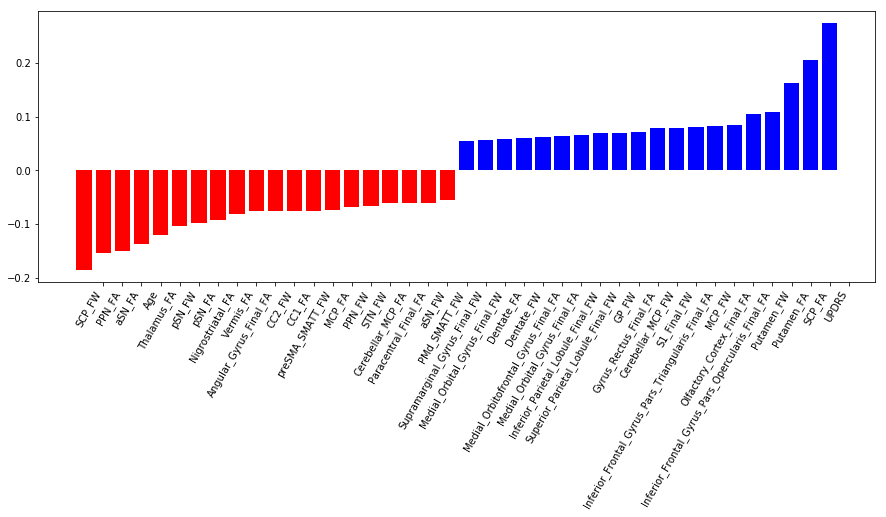

Age	-0.136409040829
Sex	-0.0408684239088
UPDRS	0.275024665333
aSN_FA	-0.149188410171
Caudate_FA	-0.0192993078021
CC2_FA	-0.0246956730561
GP_FA	0.0265136804937
LobuleVI_FA	-0.0381976313152
LobuleV_FA	0.0459978555446
MCP_FA	-0.0742755079312
pSN_FA	-0.0987578471785
Putamen_FA	0.162387844256
SCP_FA	0.205724218313
STN_FA	-0.051307521595
Thalamus_FA	-0.120684730605
Vermis_FA	-0.0809031018927
RN_FA	0.0124111194893
PPN_FA	-0.154205547056
Dentate_FA	0.0591106318817
CC1_FA	-0.0755776173622
aSN_FW	-0.0599536265546
Caudate_FW	-0.0115940011855
CC2_FW	-0.0758295551283
GP_FW	0.0697418831905
LobuleVI_FW	-0.0180495574067
LobuleV_FW	0.0220088302957
MCP_FW	0.0832207237751
pSN_FW	-0.103023628875
Putamen_FW	0.109834222454
SCP_FW	-0.185488485673
STN_FW	-0.0660084277757
Thalamus_FW	-0.0427216064969
Vermis_FW	0.0273440190972
RN_FW	-0.045285295148
PPN_FW	-0.0687590185557
Dentate_FW	0.0601093475301
CC1_FW	-0.0171509994711
Angular_Gyrus_Final_FA	-0.0760822622479
Anterior_Orbital_Gyrus_Final_FA	0.0392220985714
Ca

In [45]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.89      0.83      0.86        30
        1.0       0.67      0.77      0.71        13

avg / total       0.82      0.81      0.82        43



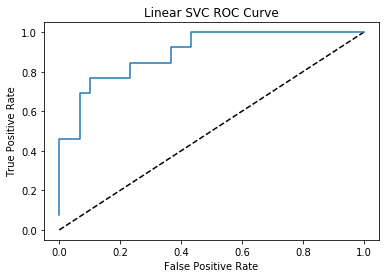

0.0 0.0769230769231
0.0 0.461538461538
0.0666666666667 0.461538461538
0.0666666666667 0.692307692308
0.1 0.692307692308
0.1 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.366666666667 0.846153846154
0.366666666667 0.923076923077
0.433333333333 0.923076923077
0.433333333333 1.0
1.0 1.0


In [46]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)